In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import model
from skimage import io,transform
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as skshuffle
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import glob
slim = tf.contrib.slim

INPUT_SIZE = [224, 224, 3]
N_CLASSES = 120
LEARNING_RATE = 2e-5
EPOCHS = 60
BATCH_SIZE = 16
LOAD_PRETRAIN = True
CSV_FILE = './labels.csv'
TRAIN_ROOT = './train'
TEST_ROOT  = './test'
all_label = set()
all_label_dict = dict()
test_id = []
train_data = []
train_label = []
test_data = []
# test_ans = []

def to_ohe(a, n_class, dtype=np.float32):
    one_hot = np.zeros((*a.shape, n_class), dtype=dtype)
    one_hot[np.arange(len(a)), a] = 1
    return one_hot


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
    
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode=ia.ALL,
            pad_cval=(5, 250)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-24, 24), # rotate by -45 to +45 degrees
            shear=(-3, 3), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(5, 250), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 3),
            [
                # sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 2.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.01, 0.05), per_channel=0.1),
                ]),
                # iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-5, 5), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-5, 5)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.Multiply((0.95, 1.05), per_channel=0.5),
                sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)), 
                iaa.Sometimes(0.7, iaa.PerspectiveTransform(scale=(0.01, 0.1))),
                sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

def train_eval(sess, x_data, y_label, batch_size, train_phase=True, is_eval=False, epoch=0, shuffle=True, verbose=True, jitter=False):
    n_sample = x_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    tmp_loss, tmp_acc = 0, 0
    if shuffle:
        x_data, y_label = skshuffle(x_data, y_label) # random shuffle at the beginning of each epoch (more 'stockchastic' ?)
    for batch in range(n_batch):
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        x_ = seq.augment_images(x_data[start:end]) if jitter else x_data[start:end]
        if is_eval:
            batch_loss, batch_acc = sess.run([loss, accuracy], 
                                            feed_dict={x: x_, y: y_label[start:end], 
                                            is_training: False})
        else:
            _, batch_loss, batch_acc = sess.run([train_op, loss, accuracy], 
                                            feed_dict={x: x_ , y: y_label[start:end], 
                                            is_training: train_phase})
        if verbose and not is_eval:
            print('epoch: {0}, [{1}/{2}], loss: {3:.4f}, acc: {4:.4f}          \r'.format(epoch+1, batch, n_batch, batch_loss, batch_acc), end='')
        tmp_loss += batch_loss * (end - start)
        tmp_acc += batch_acc * (end - start)
    if verbose and not is_eval:
        print('')
    tmp_loss /= n_sample
    tmp_acc /= n_sample
    if is_eval and verbose:
        print('val_loss: {0:.4f}, acc: {1:.4f}'.format(tmp_loss, tmp_acc))
    return tmp_loss, tmp_acc
        
def test_eval(sess, x_data, train_phase):
    batch_size = 1
    n_sample = x_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    tmp_pred=[]
    log=[]
    for batch in range(n_batch):
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        tmp_logits = sess.run(logits, feed_dict={x: x_data[start:end], is_training: train_phase})
        tmp=softmax(np.squeeze(tmp_logits))
        tmp_pred.append(tmp)
    tmp_pred = np.array(tmp_pred)

    return tmp_pred


/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# data preprocess by yourself 

train_label_csv = pd.read_csv(CSV_FILE)

print('Reading data...')

for id_, label in tqdm(zip(train_label_csv['id'], train_label_csv['breed']), total=len(train_label_csv['id'])):
    train_label += [label]
    img = imread(os.path.join(TRAIN_ROOT, str(id_)+'.jpg'), as_grey=False)[...,:3]
    if img.shape[0]!=224 or img.shape[1]!=224:
        img = resize(img, (224,224), preserve_range=True, mode='constant')
    train_data += [img.astype(np.uint8)]

all_label = list(sorted(list(set(train_label)))) # sorted list of labels
for n, label in enumerate(all_label):
    all_label_dict[label] = n 
for n, label in enumerate(train_label):
    train_label[n] = all_label_dict[label]


  0%|          | 15/10222 [00:00<01:10, 144.62it/s]

Reading data...


100%|██████████| 10222/10222 [01:08<00:00, 149.70it/s]


In [3]:
train_label = to_ohe(np.asarray(train_label, dtype=np.int32), N_CLASSES, np.float32)
train_data  = np.asarray(train_data, dtype=np.uint8)

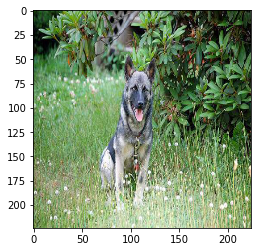

In [4]:
plt.imshow(train_data[np.random.randint(len(train_data))])
plt.show()

In [5]:
test_ps = glob.glob(TEST_ROOT+'/*.jpg')
for test_img_path in tqdm(test_ps, total=len(test_ps)): # read all test images
    id_ = os.path.splitext(os.path.split(test_img_path)[-1])[0] # get id
    test_id += [id_]
    img = imread(test_img_path, as_grey=False)[...,:3]
    if img.shape[0]!=224 or img.shape[1]!=224:
        img = resize(img, (224,224), preserve_range=True, mode='constant')
    test_data += [img.astype(np.uint8)]
test_data = np.asarray(test_data, dtype=np.uint8)

100%|██████████| 10357/10357 [01:06<00:00, 154.65it/s]


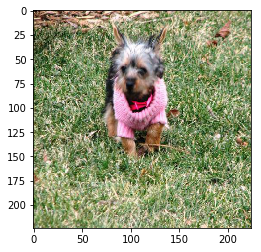

In [6]:
plt.imshow(test_data[np.random.randint(len(test_data))])
plt.show()

In [7]:
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size=0.2, shuffle=True, stratify=train_label)

In [8]:
print(train_data.shape)
print(val_data.shape)
print(train_label.shape)
print(val_label.shape)

(8177, 224, 224, 3)
(2045, 224, 224, 3)
(8177, 120)
(2045, 120)


INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt
Loaded pretrained weights
epoch: 1, [511/512], loss: 5.3642, acc: 0.0000          
val_loss: 4.0814, acc: 0.1134
epoch: 2, [511/512], loss: 3.8828, acc: 0.0000          
val_loss: 3.5978, acc: 0.2068
epoch: 3, [511/512], loss: 2.8058, acc: 0.0000          
val_loss: 3.2624, acc: 0.2758
epoch: 4, [511/512], loss: 4.9688, acc: 0.0000          
val_loss: 3.0017, acc: 0.3208
epoch: 5, [511/512], loss: 3.8528, acc: 0.0000          
val_loss: 2.8159, acc: 0.3579
epoch: 6, [511/512], loss: 3.1246, acc: 0.0000          
val_loss: 2.6750, acc: 0.3697
epoch: 7, [511/512], loss: 1.6013, acc: 1.0000          
val_loss: 2.5504, acc: 0.4005
epoch: 8, [511/512], loss: 1.5630, acc: 1.0000          
val_loss: 2.4452, acc: 0.4196
epoch: 9, [511/512], loss: 1.6668, acc: 1.0000          
val_loss: 2.3756, acc: 0.4196
epoch: 10, [511/512], loss: 1.4345, acc: 1.0000          
val_loss: 2.2880, acc: 0.4372
epoch: 11, [511/512], loss: 0.7873, acc: 1.0000

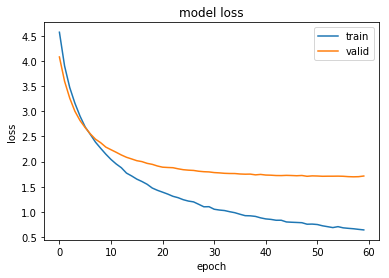

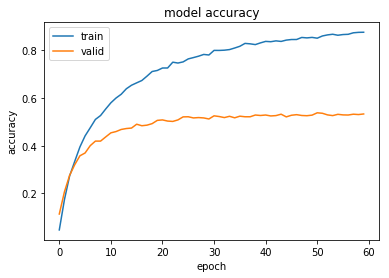

In [9]:
x = tf.placeholder(dtype=tf.float32, shape=(None, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2]), name='x')
y = tf.placeholder(dtype=tf.float32, shape=(None, N_CLASSES), name='y')
is_training = tf.placeholder(dtype=tf.bool, shape=(), name='train_phase')

logits = model.VGG16(inputs=x, n_classes=N_CLASSES, freeze=True)

with tf.name_scope('LossLayer'):
    loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logits)
with tf.name_scope('Optimizer'):
    train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
with tf.name_scope('Accuracy'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), tf.argmax(logits, axis=1)), tf.float32))

init = tf.global_variables_initializer()

saver  = tf.train.Saver()
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
    
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []

if not os.path.exists('./model'):
    os.makedirs('./model')
    
with tf.Session(config=config) as sess:
    init_op = tf.group(tf.global_variables_initializer(),
            tf.local_variables_initializer())
    sess.run(init_op)
    if LOAD_PRETRAIN:
        if not os.path.exists('./vgg_16.ckpt'):
            if not os.path.exists('./vgg_16_2016_08_28.tar.gz'):
                print('Downloading pre-trained weights from ImageNet...')
                ! wget "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
            print('Untar vgg16...')
            ! tar -zxvf "./vgg_16_2016_08_28.tar.gz" 
            print('Done')
        restore = slim.assign_from_checkpoint_fn(
               './vgg_16.ckpt',
               slim.get_model_variables("vgg_16"))
        restore(sess)
        print('Loaded pretrained weights')

    for i in range(EPOCHS):
        loss_, acc_ = train_eval(sess=sess, x_data=train_data, y_label=train_label, batch_size=BATCH_SIZE, 
                    train_phase=True, is_eval=False,epoch=i, shuffle=True, jitter=True) # train
        val_loss_, val_acc_ = train_eval(sess=sess, x_data=val_data, y_label=val_label, batch_size=BATCH_SIZE, 
                    train_phase=False, is_eval=True, epoch=0, shuffle=False, jitter=False) # validation
        loss_history += [loss_]
        acc_history  += [acc_]
        val_loss_history += [val_loss_]
        val_acc_history  += [val_acc_]
        
        saver.save(sess, 'model/model_{:02d}.ckpt'.format(i))
    ans = test_eval(sess=sess, x_data=test_data, train_phase=False)
    
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()
    
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [10]:
sub = pd.DataFrame()
sub['id'] = test_id
for n, label in tqdm(enumerate(all_label), total=len(all_label)):
    sub[label] = ans[:,n]
sub.to_csv('submission.csv', index=False)

100%|██████████| 120/120 [00:00<00:00, 5935.55it/s]
